Expedia is the world’s largest online travel agency (OTA) and powers search results for millions of travel shoppers every day. In this competitive market matching users to hotel inventory is very important since users easily jump from website to website. As such, **having the best ranking of hotels (“sort”) for specific users with the best integration of price competitiveness gives an OTA the best chance of winning the sale.**

For this contest, Expedia has provided a dataset that includes shopping and purchase data as well as information on price competitiveness. The data are organized around a set of “search result impressions”, or the ordered list of hotels that the user sees after they search for a hotel on the Expedia website. In addition to impressions from the existing algorithm, the data contain impressions where the hotels were randomly sorted, to avoid the position bias of the existing algorithm. The user response is provided as a click on a hotel or/and a purchase of a hotel room.

Appended to impressions are the following:

1) Hotel characteristics

2) Location attractiveness of hotels

3) User’s aggregate purchase history

4) Competitive OTA information

Models will be scored via performance on a hold-out set.

data source: https://www.kaggle.com/c/expedia-personalized-sort/data

- **train.csv** - the training set

- **test.csv** - the test set (this contains data for both the public leaderboard and the final evaluation, which is randomly split between the two sets)

Note: **test.csv** does not contain the following columns: position, click_bool, gross_bookings_usd, nor booking_bool

You can refer to www.expedia.com to better understand hotel search.

“Hotel” refers to hotels, apartments, B&Bs, hostels and other properties appearing on Expedia’s websites.  Room types are not distinguished and the data can be assumed to apply to the least expensive room type.

Most of the data are for searches that resulted in a purchase, but a small proportion are for searches not leading to a purchase.

Usage of outside data is prohibited and modeling should focus fully on the given data.


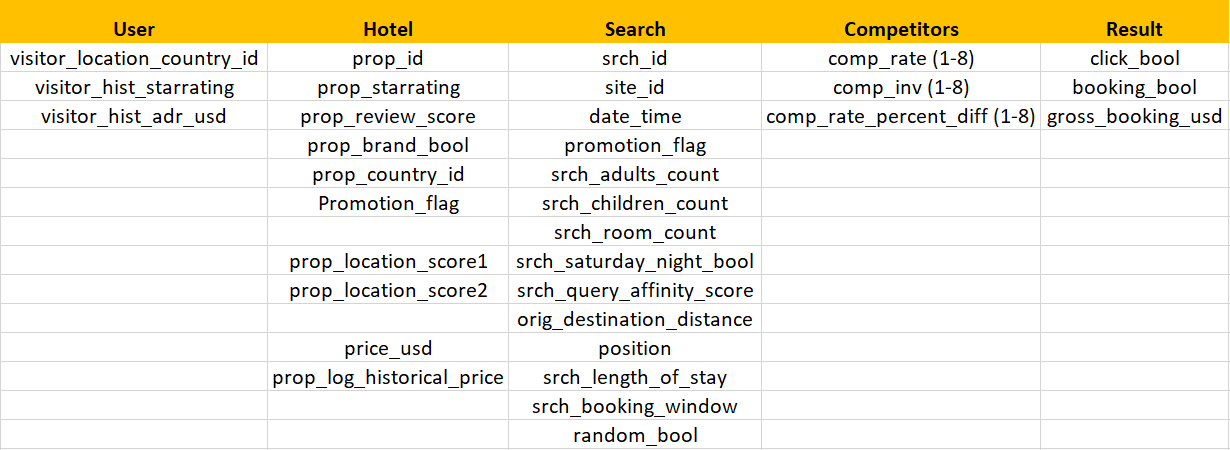

to make the features more intuitive

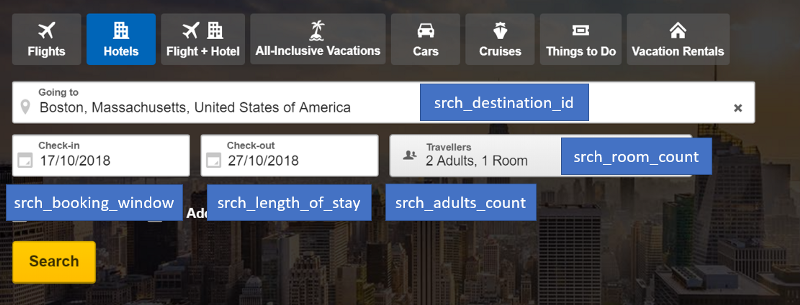

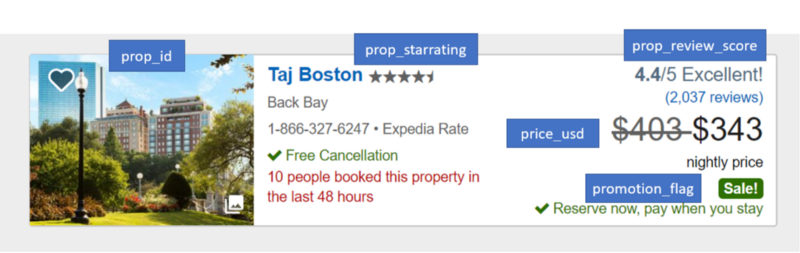

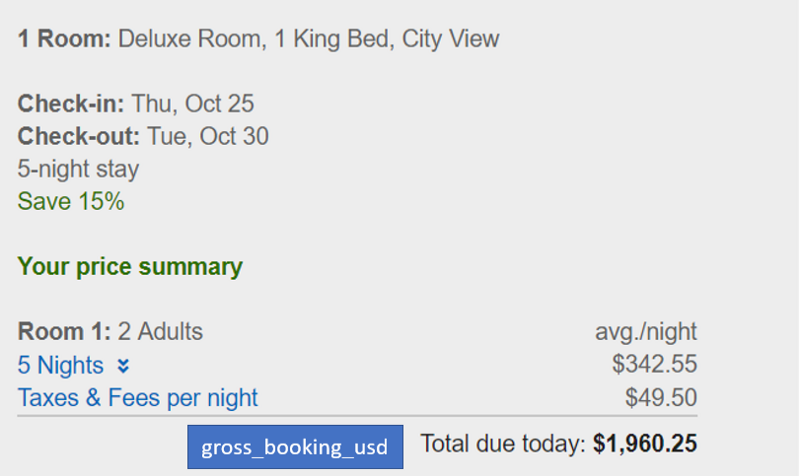

all pictures are taken from : https://towardsdatascience.com/machine-learning-model-for-predicting-click-through-in-hotel-online-ranking-d55fc18c8516

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
import numpy as np
from scipy.stats import norm, skew
import seaborn as sns
from collections import Counter
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold,train_test_split
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error,mean_squared_error


from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Lasso, Ridge
import xgboost as xgb
import lightgbm as lgb



import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

### Data preprocessing

In [2]:
# We operate with a dataset that has around 10 mln of samples

df = pd.read_csv('/volatile/Smirnov/Data_Science_Datasets/Expedia_Hotel_Searches/all/train.csv')
df = df.sample(frac=0.5, random_state=17) # 30% of the data
df.shape

(4958765, 54)

In [3]:
# Let see how many countries which offer property

len(df.prop_country_id.unique())

172

In [4]:
# Display top-10 countries id with most offered properties

df.groupby('prop_country_id').size().nlargest(10)

prop_country_id
219    3026447
100     311907
55      187708
31      154337
99      134164
129      92384
215      80555
220      70815
59       69358
216      62345
dtype: int64

In [5]:
# Percent-wise

df['prop_country_id'].value_counts(normalize=True).nlargest(10)

219    0.610323
100    0.062900
55     0.037854
31     0.031124
99     0.027056
129    0.018630
215    0.016245
220    0.014281
59     0.013987
216    0.012573
Name: prop_country_id, dtype: float64

In [6]:
# Display top-10 countries with most amount of users who are looking to book a property

df.groupby('visitor_location_country_id').size().nlargest(10)

visitor_location_country_id
219    2889573
100     495932
55      289787
216     217708
220     174830
129     125189
31       92495
99       68700
59       61730
92       46720
dtype: int64

In [7]:
# Percent-wise

df['visitor_location_country_id'].value_counts(normalize=True).nlargest(10)

219    0.582720
100    0.100011
55     0.058439
216    0.043904
220    0.035257
129    0.025246
31     0.018653
99     0.013854
59     0.012449
92     0.009422
Name: visitor_location_country_id, dtype: float64

We observe that the top-3 countries are the same for both, user location and destination. The data is anonymized, so determining the exact country or city to which a consumer plans to travel to is not possible. However, it is evident that the largest country (labeled 219) is the United States. The largest country has 61% of all observations. Out of those, 58% of searches are made by consumers also located in this country, suggesting that the country has a large territory with a large fraction of domestic travel. The price currency `price_usd`,`gross_bookings_usd` also suggested that the largest country being the United States.

To reduce the computational complexity due to the large size of the dataset, we will further proceed with only data from US. 

In [8]:
df.columns

Index([u'srch_id', u'date_time', u'site_id', u'visitor_location_country_id',
       u'visitor_hist_starrating', u'visitor_hist_adr_usd', u'prop_country_id',
       u'prop_id', u'prop_starrating', u'prop_review_score',
       u'prop_brand_bool', u'prop_location_score1', u'prop_location_score2',
       u'prop_log_historical_price', u'position', u'price_usd',
       u'promotion_flag', u'srch_destination_id', u'srch_length_of_stay',
       u'srch_booking_window', u'srch_adults_count', u'srch_children_count',
       u'srch_room_count', u'srch_saturday_night_bool',
       u'srch_query_affinity_score', u'orig_destination_distance',
       u'random_bool', u'comp1_rate', u'comp1_inv', u'comp1_rate_percent_diff',
       u'comp2_rate', u'comp2_inv', u'comp2_rate_percent_diff', u'comp3_rate',
       u'comp3_inv', u'comp3_rate_percent_diff', u'comp4_rate', u'comp4_inv',
       u'comp4_rate_percent_diff', u'comp5_rate', u'comp5_inv',
       u'comp5_rate_percent_diff', u'comp6_rate', u'comp6_inv',
  

In [9]:
df.shape

(4958765, 54)

In [10]:
df.isnull().sum()

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        4706541
visitor_hist_adr_usd           4705400
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                 7263
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           1089064
prop_log_historical_price            0
position                             0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      4640666
orig_destination_distance

In [11]:
usa = df.loc[df["visitor_location_country_id"] == 219]
usa.head(5)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1478499,99143,2013-06-10 04:00:38,5,219,NaN,NaN,219,74344,3,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
6971046,468147,2012-11-10 12:21:39,5,219,NaN,NaN,219,67964,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3923478,263344,2013-02-19 12:38:46,5,219,NaN,NaN,219,137161,3,5.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
982566,65633,2013-05-13 16:47:54,5,219,NaN,NaN,219,122618,2,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3332016,223735,2013-06-10 10:54:52,5,219,NaN,NaN,18,64883,4,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [12]:
usa.shape

(2889573, 54)

In [13]:
# Delete uncessary colum

del usa["visitor_location_country_id"]
usa.head(5)

,srch_id,date_time,site_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
1478499,99143,2013-06-10 04:00:38,5,NaN,NaN,219,74344,3,4.0,1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
6971046,468147,2012-11-10 12:21:39,5,NaN,NaN,219,67964,4,3.5,0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3923478,263344,2013-02-19 12:38:46,5,NaN,NaN,219,137161,3,5.0,1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
982566,65633,2013-05-13 16:47:54,5,NaN,NaN,219,122618,2,4.0,1,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3332016,223735,2013-06-10 10:54:52,5,NaN,NaN,18,64883,4,4.0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,0


In [14]:
usa.isnull().sum()

srch_id                            0
date_time                          0
site_id                            0
visitor_hist_starrating      2771903
visitor_hist_adr_usd         2771252
prop_country_id                    0
prop_id                            0
prop_starrating                    0
prop_review_score               2687
prop_brand_bool                    0
prop_location_score1               0
prop_location_score2          670375
prop_log_historical_price          0
position                           0
price_usd                          0
promotion_flag                     0
srch_destination_id                0
srch_length_of_stay                0
srch_booking_window                0
srch_adults_count                  0
srch_children_count                0
srch_room_count                    0
srch_saturday_night_bool           0
srch_query_affinity_score    2645581
orig_destination_distance     360149
random_bool                        0
comp1_rate                   2854921
c

In [15]:
columns_to_drop = ['click_bool','visitor_hist_starrating','visitor_hist_adr_usd','prop_country_id', 'site_id', 
                   'srch_query_affinity_score', 'comp1_rate', 'srch_destination_id','comp1_inv', 
                   'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 
                   'comp3_rate_percent_diff', 'comp4_rate_percent_diff', 
                   'comp5_rate_percent_diff', 'comp6_rate_percent_diff', 
                   'comp7_rate_percent_diff', 'comp8_rate_percent_diff', 
                   'comp2_rate', 'comp3_rate', 'comp4_rate', 'comp5_rate', 
                   'comp6_rate', 'comp7_rate', 'comp8_rate', 'comp2_inv', 
                   'comp3_inv', 'comp4_inv', 'comp5_inv', 'comp6_inv', 'comp7_inv', 
                   'comp8_inv', 'gross_bookings_usd', 'srch_id']

usa.drop(columns_to_drop, axis=1, inplace = True)
usa.head()

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool
1478499,2013-06-10 04:00:38,74344,3,4.0,1,1.10,0.0044,0.00,7,79.0,0,3,25,2,0,1,1,455.25,0,0
6971046,2012-11-10 12:21:39,67964,4,3.5,0,5.07,0.0510,5.26,6,177.0,1,5,22,1,0,1,0,38.27,0,0
3923478,2013-02-19 12:38:46,137161,3,5.0,1,1.39,NaN,4.75,3,100.0,1,2,1,2,0,1,0,530.30,0,0
982566,2013-05-13 16:47:54,122618,2,4.0,1,1.79,0.4523,4.68,6,120.0,0,1,0,4,0,2,0,45.35,0,0
3332016,2013-06-10 10:54:52,64883,4,4.0,1,3.09,NaN,0.00,33,206.0,1,3,22,2,2,1,0,1559.34,1,0


In [16]:
usa.isnull().sum()

date_time                         0
prop_id                           0
prop_starrating                   0
prop_review_score              2687
prop_brand_bool                   0
prop_location_score1              0
prop_location_score2         670375
prop_log_historical_price         0
position                          0
price_usd                         0
promotion_flag                    0
srch_length_of_stay               0
srch_booking_window               0
srch_adults_count                 0
srch_children_count               0
srch_room_count                   0
srch_saturday_night_bool          0
orig_destination_distance    360149
random_bool                       0
booking_bool                      0
dtype: int64

In [17]:
usa.shape

(2889573, 20)

### Filling missing values

We are going to impute three features that contain less than 30% of NaN value, they are: `prop_review_score`, `prop_location_score2` and `orig_destination_distance`.

In [18]:
# Randomly impute “prop_review_score”
# we will randomise missing data for DataFrame (within a column)"

# Define indexes of Nan elements in this df 
mask = usa['prop_review_score'].isnull() 

# Randomly pick non-zero array of size 'k' from the column of df 
samples = random.sample(usa['prop_review_score'][~mask].values,k = mask.sum())

# Substitute zero elements with randomly picked non zero from the same column 
usa['prop_review_score'][mask] = samples
usa.head(10)

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool
1478499,2013-06-10 04:00:38,74344,3,4.0,1,1.10,0.0044,0.00,7,79.0,0,3,25,2,0,1,1,455.25,0,0
6971046,2012-11-10 12:21:39,67964,4,3.5,0,5.07,0.0510,5.26,6,177.0,1,5,22,1,0,1,0,38.27,0,0
3923478,2013-02-19 12:38:46,137161,3,5.0,1,1.39,NaN,4.75,3,100.0,1,2,1,2,0,1,0,530.30,0,0
982566,2013-05-13 16:47:54,122618,2,4.0,1,1.79,0.4523,4.68,6,120.0,0,1,0,4,0,2,0,45.35,0,0
3332016,2013-06-10 10:54:52,64883,4,4.0,1,3.09,NaN,0.00,33,206.0,1,3,22,2,2,1,0,1559.34,1,0
5399342,2013-05-01 17:04:43,49092,3,5.0,1,1.10,0.0368,4.72,6,109.0,0,3,1,1,0,1,1,NaN,0,1
2027792,2012-11-04 15:51:29,109162,0,0.0,0,1.10,0.2167,4.94,7,91.0,0,1,3,2,0,1,0,NaN,0,0
9746189,2013-01-01 13:24:43,127400,5,4.5,0,1.79,0.0549,6.21,3,376.0,1,7,9,1,0,1,0,1855.02,0,0
6914399,2012-11-05 17:29:43,105517,2,3.5,1,3.09,0.0064,4.41,6,63.0,1,1,5,3,2,1,1,365.93,0,0
9211240,2013-06-10 19:03:39,138105,3,4.5,0,3.37,0.0267,0.00,2,189.0,0,1,47,2,0,1,1,NaN,0,0


This method eliminates the imputation variance of the estimator of a mean or total, and at the same time preserves the distribution of item values.

In [19]:
# Make sure that we dont have zero elements anymore
usa.prop_review_score.isnull().sum()

0

In [20]:
# Now we impute 'prop_location_score2' with mean

print(usa['prop_location_score2'].mean())

usa['prop_location_score2'].fillna((usa['prop_location_score2'].mean()), inplace=True)

# Mean has slightly changed 
print(usa['prop_location_score2'].mean())

0.1243398544879726
0.12433985448797265


In [21]:
# Now we impute 'orig_destination_distance' with median

print(usa['orig_destination_distance'].median())

usa['orig_destination_distance'].fillna((usa['orig_destination_distance'].median()), inplace=True)

# Median has not changed 

print(usa['orig_destination_distance'].median())

339.51
339.51


In [22]:
usa.shape

(2889573, 20)

### Feature Engineering

In [23]:
# The difference between the logarithm of the mean price of the hotel over the last trading period and offered price

usa['hist_price_diff_hotel'] = np.exp(usa['prop_log_historical_price'].values) - usa['price_usd']

# Cost per day

usa['cost_per_day'] = usa['price_usd'] / usa['srch_length_of_stay']
usa['cost_per_day'] = np.around(usa['cost_per_day'].values, decimals=2)

In [24]:
usa['cost_per_day'].min(),usa['cost_per_day'].max()

(0.01, 722556.0)

In [25]:
usa.head()

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,...,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day
1478499,2013-06-10 04:00:38,74344,3,4.0,1,1.10,0.00440,0.00,7,79.0,...,25,2,0,1,1,455.25,0,0,-78.000000,26.33
6971046,2012-11-10 12:21:39,67964,4,3.5,0,5.07,0.05100,5.26,6,177.0,...,22,1,0,1,0,38.27,0,0,15.481491,35.40
3923478,2013-02-19 12:38:46,137161,3,5.0,1,1.39,0.12434,4.75,3,100.0,...,1,2,0,1,0,530.30,0,0,15.584285,50.00
982566,2013-05-13 16:47:54,122618,2,4.0,1,1.79,0.45230,4.68,6,120.0,...,0,4,0,2,0,45.35,0,0,-12.229927,120.00
3332016,2013-06-10 10:54:52,64883,4,4.0,1,3.09,0.12434,0.00,33,206.0,...,22,2,2,1,0,1559.34,1,0,-205.000000,68.67


In [26]:
usa.shape

(2889573, 22)

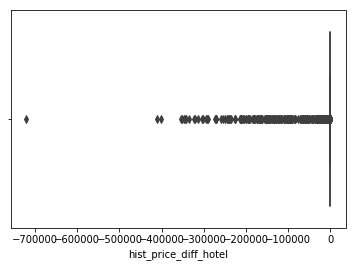

In [27]:
sns.boxplot(x='hist_price_diff_hotel', data = usa);

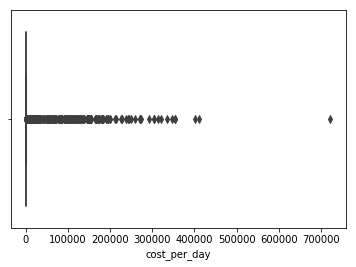

In [28]:
sns.boxplot(x='cost_per_day', data=usa);

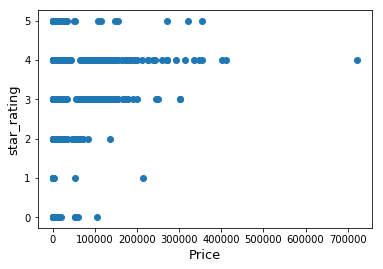

In [29]:
fig, ax = plt.subplots()
ax.scatter(usa['cost_per_day'], usa['prop_starrating'])
plt.ylabel('star_rating', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

There are definetely a few outliers

In [30]:
print('Dataframe shape before removing an outlier: {}'.format(usa.shape))

usa = usa.drop(usa[usa['price_usd']> 700000].index)
usa = usa.drop((usa[(usa['prop_starrating']== 1) & (usa['price_usd']> 200000)].index))
usa = usa.drop((usa[(usa['prop_starrating']== 3) & (usa['price_usd']> 300000)].index))


print('Dataframe shape after removing an outlier: {}'.format(usa.shape))

Dataframe shape before removing an outlier: (2889573, 22)
Dataframe shape after removing an outlier: (2889568, 22)


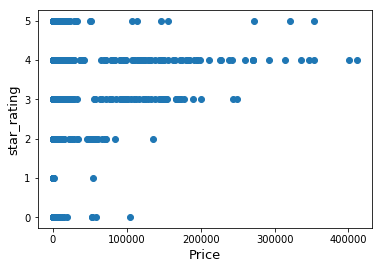

In [31]:
fig, ax = plt.subplots()
ax.scatter(usa['cost_per_day'], usa['prop_starrating'])
plt.ylabel('star_rating', fontsize=13)
plt.xlabel('Price', fontsize=13)
plt.show()

In [32]:
usa.head()

,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,price_usd,...,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day
1478499,2013-06-10 04:00:38,74344,3,4.0,1,1.10,0.00440,0.00,7,79.0,...,25,2,0,1,1,455.25,0,0,-78.000000,26.33
6971046,2012-11-10 12:21:39,67964,4,3.5,0,5.07,0.05100,5.26,6,177.0,...,22,1,0,1,0,38.27,0,0,15.481491,35.40
3923478,2013-02-19 12:38:46,137161,3,5.0,1,1.39,0.12434,4.75,3,100.0,...,1,2,0,1,0,530.30,0,0,15.584285,50.00
982566,2013-05-13 16:47:54,122618,2,4.0,1,1.79,0.45230,4.68,6,120.0,...,0,4,0,2,0,45.35,0,0,-12.229927,120.00
3332016,2013-06-10 10:54:52,64883,4,4.0,1,3.09,0.12434,0.00,33,206.0,...,22,2,2,1,0,1559.34,1,0,-205.000000,68.67


In [33]:
# Take date_time feature, overall we have 7 months data
# ('2012-11-01 00:08:29', '2013-06-30 23:57:52')

data_time_feature = usa['date_time']
print(data_time_feature.shape)

# Re-group columns
cols = list(usa.columns.values) 
cols.pop(cols.index('price_usd')) #Remove b from list
usa = usa[cols+['price_usd']]
usa.head(5)

(2889568,)


,date_time,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,...,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,price_usd
1478499,2013-06-10 04:00:38,74344,3,4.0,1,1.10,0.00440,0.00,7,0,...,2,0,1,1,455.25,0,0,-78.000000,26.33,79.0
6971046,2012-11-10 12:21:39,67964,4,3.5,0,5.07,0.05100,5.26,6,1,...,1,0,1,0,38.27,0,0,15.481491,35.40,177.0
3923478,2013-02-19 12:38:46,137161,3,5.0,1,1.39,0.12434,4.75,3,1,...,2,0,1,0,530.30,0,0,15.584285,50.00,100.0
982566,2013-05-13 16:47:54,122618,2,4.0,1,1.79,0.45230,4.68,6,0,...,4,0,2,0,45.35,0,0,-12.229927,120.00,120.0
3332016,2013-06-10 10:54:52,64883,4,4.0,1,3.09,0.12434,0.00,33,1,...,2,2,1,0,1559.34,1,0,-205.000000,68.67,206.0


Another approach to deal with outliers is not being selective but apply Tukey transformation.

In [34]:
def outliers(df,n,features):
    
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col].dropna(), 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col].dropna(), 75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   
    

In [35]:
usa.columns

Index([u'date_time', u'prop_id', u'prop_starrating', u'prop_review_score',
       u'prop_brand_bool', u'prop_location_score1', u'prop_location_score2',
       u'prop_log_historical_price', u'position', u'promotion_flag',
       u'srch_length_of_stay', u'srch_booking_window', u'srch_adults_count',
       u'srch_children_count', u'srch_room_count', u'srch_saturday_night_bool',
       u'orig_destination_distance', u'random_bool', u'booking_bool',
       u'hist_price_diff_hotel', u'cost_per_day', u'price_usd'],
      dtype='object')

In [36]:
usa.shape

(2889568, 22)

In [37]:
len(usa.prop_id.unique())

91299

### EDA will be skipped and We Go directly to training part

In [38]:
hotel_id = usa['prop_id']
usa = usa.drop(['prop_id','date_time'], axis=1)
print(hotel_id.shape, usa.shape)

((2889568,), (2889568, 20))


In [39]:
print(usa.shape)

(2889568, 20)


In [40]:
usa.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,price_usd
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,2,0,1,1,455.25,0,0,-78.000000,26.33,79.0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,1,0,1,0,38.27,0,0,15.481491,35.40,177.0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,2,0,1,0,530.30,0,0,15.584285,50.00,100.0
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,4,0,2,0,45.35,0,0,-12.229927,120.00,120.0
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,2,2,1,0,1559.34,1,0,-205.000000,68.67,206.0


In [41]:
# Create a train and test sets

msk = np.random.rand(len(usa)) < 0.7

train = usa[msk]
test = usa[~msk]

len(train), len(test)

(2022843, 866725)

In [42]:
train.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,price_usd
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,2,0,1,1,455.25,0,0,-78.000000,26.33,79.0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,1,0,1,0,38.27,0,0,15.481491,35.40,177.0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,2,0,1,0,530.30,0,0,15.584285,50.00,100.0
5399342,3,5.0,1,1.10,0.03680,4.72,6,0,3,1,1,0,1,1,339.51,0,1,3.168253,36.33,109.0
2027792,0,0.0,0,1.10,0.21670,4.94,7,0,1,3,2,0,1,0,339.51,0,0,48.770250,91.00,91.0


In [43]:
# Target labels for the training set and the traiing set itself

Y = train.iloc[:,-1].as_matrix()
X = train.drop([usa.columns[-1]], axis=1).as_matrix()

X_train, X_holdout, y_train, y_holdout = train_test_split(X, Y, test_size=0.3, 
                                                          random_state=17)

In [44]:
# Model Validation

n_folds = 5

def rmse_mae(model):
    
    kf = KFold(n_folds, shuffle=True, random_state=17).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    mae = np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_absolute_error", cv = kf))
    
    return rmse,mae

In [45]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

Ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.0005, random_state=5))

#KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

GBoost = GradientBoostingRegressor(n_estimators=1500, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [46]:
%%time

score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))


Lasso score RMSE: 56.6114 (0.1775)

Ridge score RMSE: 56.6114 (0.1775)

ElasticNet score RMSE: 56.6115 (0.1775)

Xgboost score RMSE: 78.9977 (33.4943)

LGBM score RMSE: 1229.3600 (368.7084)


Lasso score MAE: 6.4342 (0.0055)

Ridge score RMSE: 6.4342 (0.0055)

ElasticNet score MAE: 6.4342 (0.0055)

Xgboost score MAE: 1.8559 (0.0991)

LGBM score MAE: 7.0257 (0.0763)

CPU times: user 6h 8min 49s, sys: 21.9 s, total: 6h 9min 11s
Wall time: 53min 26s


Well, apparently xgb boost is working way better than others according to **RMSE** and **MAE** metrics. Lets have a look at the perfomance on the test set.

In [47]:
def rmse(y_pred,y_true):
    result = np.sqrt(mean_squared_error(y_true,y_pred))
    
    return result

def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))

In [48]:
regressions(ENet)

MAE : 41.307730
RMSE : 56.429583
R2 : 0.998287


In [49]:
regressions(lasso)

MAE : 41.307906
RMSE : 56.429611
R2 : 0.998287


In [50]:
regressions(Ridge)

MAE : 41.307917
RMSE : 56.429613
R2 : 0.998287


In [51]:
regressions(model_xgb)

MAE : 3.478208
RMSE : 141.892091
R2 : 0.989167


In [52]:
regressions(model_lgb)

MAE : 47.342714
RMSE : 1293.566924
R2 : 0.099690


#### Lets make some predictions with XG boost seems it is working better than others

In [53]:
true_price = test.iloc[:,-1];
test_predict = test.drop([test.columns[-1]], axis=1)
test_predict.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,4,0,2,0,45.35,0,0,-12.229927,120.00
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,2,2,1,0,1559.34,1,0,-205.000000,68.67
9746189,5,4.5,0,1.79,0.05490,6.21,3,1,7,9,1,0,1,0,1855.02,0,0,121.701251,53.71
9204361,4,4.0,1,3.83,0.34410,5.71,19,1,3,5,1,0,1,1,339.51,1,0,182.871068,39.67
1230961,4,4.0,1,4.47,0.14500,0.00,1,0,3,0,1,2,1,1,183.49,1,0,-291.000000,97.33


In [54]:
test_predict['estimated_prices_usd'] = model_xgb.predict(test_predict.values)
test_predict['price_usd'] = true_price
test_predict['price_difference'] = test_predict['price_usd'] - test_predict['estimated_prices_usd']
test_predict.head(5)

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,estimated_prices_usd,price_usd,price_difference
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,2,0,45.35,0,0,-12.229927,120.00,122.949432,120.0,-2.949432
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,1,0,1559.34,1,0,-205.000000,68.67,209.028595,206.0,-3.028595
9746189,5,4.5,0,1.79,0.05490,6.21,3,1,7,9,...,1,0,1855.02,0,0,121.701251,53.71,380.817017,376.0,-4.817017
9204361,4,4.0,1,3.83,0.34410,5.71,19,1,3,5,...,1,1,339.51,1,0,182.871068,39.67,117.336563,119.0,1.663437
1230961,4,4.0,1,4.47,0.14500,0.00,1,0,3,0,...,1,1,183.49,1,0,-291.000000,97.33,299.133575,292.0,-7.133575


In [55]:
test_predict = test_predict.rename(columns={'prop_log_historical_price':'log_hist_price', 'srch_length_of_stay': 'length_of_stay',
                                 'prop_starrating':'star_rating', 'orig_destination_distance':'dest_distance',
                                 })

In [56]:
#Lets find and plot features which are actually important for out XGB model

feature_importance = model_xgb.feature_importances_
feature_importance

array([0.05284091, 0.04723011, 0.00866477, 0.06015625, 0.02961648,
       0.10916193, 0.02151989, 0.01555398, 0.078125  , 0.03544034,
       0.00369318, 0.01022727, 0.00071023, 0.00710227, 0.06463068,
       0.01200284, 0.00042614, 0.2328125 , 0.21008523], dtype=float32)

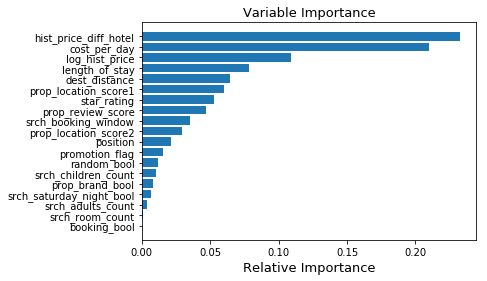

In [57]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_predict.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=13)
plt.title('Variable Importance',fontsize=13)
plt.show()

- `prop_log_historical_price` - The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.

- `orig_destination_distance` - Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated.

[0.5 1.5 2.5 3.5 4.5]


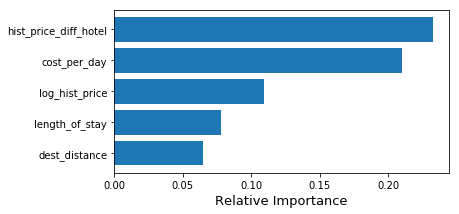

In [58]:
sorted_idx = np.argsort(feature_importance) # return indexes of the elements sorted in ascending order
sorted_idx = sorted_idx[-5:]
pos = np.arange(sorted_idx[-5:].shape[0]) + .5
print(pos)
plt.subplots(figsize=(6,3))
plt.barh(pos, feature_importance[sorted_idx[-5:]], align='center')
plt.yticks(pos, test_predict.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=13)
#plt.title('Feature Importance',fontsize=13)
plt.show()

#### Lets have a look at residuals

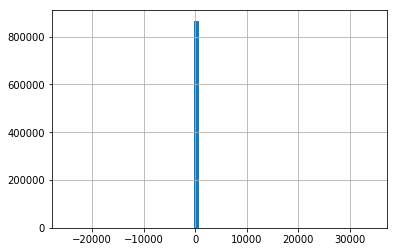

In [59]:
test_predict['price_difference'].hist(bins=60)

Text(0,0.5,'Price difference')

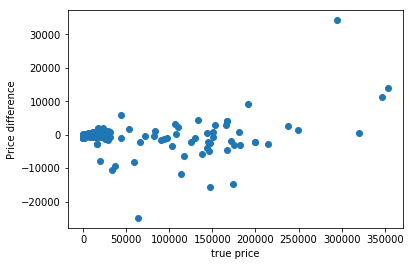

In [60]:
plt.scatter(test_predict.price_usd,test_predict.price_difference)
plt.xlabel("true price")
plt.ylabel("Price difference")

From the above plot we see that at least for one hotel the price is too high (to compare to the estimated price), hence this might be an outlier.

## Results are really good but what about skeweness of the target vector

One more interesting thing to test is to log-transform the price in order have a more **Normal** distribution of the target (dependent) variable.

In [61]:
train.head(5)

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,price_usd
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,2,0,1,1,455.25,0,0,-78.000000,26.33,79.0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,1,0,1,0,38.27,0,0,15.481491,35.40,177.0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,2,0,1,0,530.30,0,0,15.584285,50.00,100.0
5399342,3,5.0,1,1.10,0.03680,4.72,6,0,3,1,1,0,1,1,339.51,0,1,3.168253,36.33,109.0
2027792,0,0.0,0,1.10,0.21670,4.94,7,0,1,3,2,0,1,0,339.51,0,0,48.770250,91.00,91.0


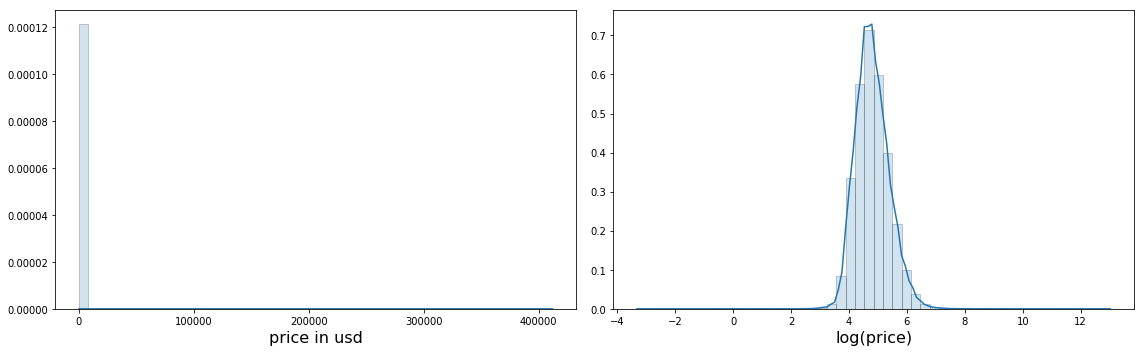

In [62]:
# Distribution of price
warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(train['price_usd'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(train['price_usd']), ax=ax[1], hist_kws=hist_kws)
ax[0].set_xlabel('price in usd', fontsize=16)
ax[1].set_xlabel('log(price)', fontsize=16)
plt.tight_layout()
plt.show()

Transformed price looks way more normal than before, lets conduct `Shapiro-Wilk` test in order to prove it.

In [64]:
from scipy import stats

stat, p = stats.shapiro(np.log(train['price_usd']))
print('Statistics=%.3f, p=%.3f' % (stat, p))

# interpret
alpha = 0.05

if p > alpha:
	print('Sample looks Gaussian (fail to reject H0)')
else:
	print('Sample does not look Gaussian (reject H0)')

Statistics=0.975, p=0.000
Sample does not look Gaussian (reject H0)


The target vector seems to be not normal, however let us conduct one more test and build Q-Q plot.

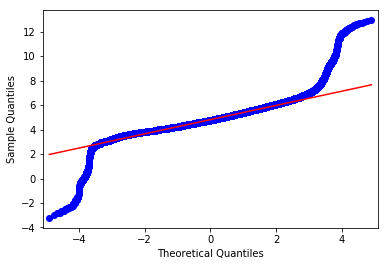

In [66]:
import statsmodels.api as sm
import pylab

sm.qqplot(np.log(train['price_usd']), line='s')

pylab.show()

The one can see that

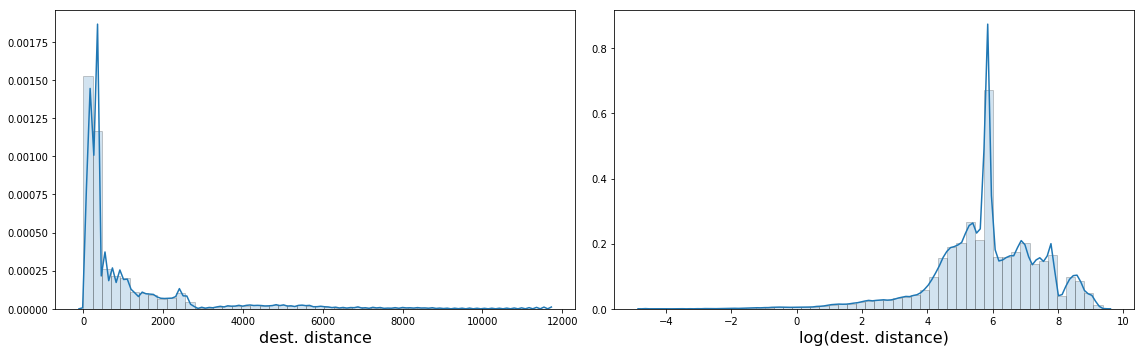

In [67]:
# Distribution of pdestination distance

warnings.filterwarnings('ignore')
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}

fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
sns.distplot(train['orig_destination_distance'], ax=ax[0], hist_kws=hist_kws)
sns.distplot(np.log(train['orig_destination_distance']), ax=ax[1], hist_kws=hist_kws)
ax[0].set_xlabel('dest. distance', fontsize=16)
ax[1].set_xlabel('log(dest. distance)', fontsize=16)
plt.tight_layout()
plt.show()

In [68]:
# Target labels for the training set and the traiing set itself
Y = train.iloc[:,-1]
X = train.drop([usa.columns[-1]], axis=1)


X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3, 
                                                          random_state=17)

# transform into log scale
y_train = np.log(y_train)
y_holdout = np.log(y_holdout)

In [69]:
score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))

Lasso score RMSE: 0.4550 (0.0020)

Ridge score RMSE: 0.4550 (0.0020)

ElasticNet score RMSE: 0.4550 (0.0020)

Xgboost score RMSE: 0.0166 (0.0002)

LGBM score RMSE: 0.1057 (0.0034)


Lasso score MAE: 0.5846 (0.0003)

Ridge score RMSE: 0.5846 (0.0003)

ElasticNet score MAE: 0.5846 (0.0003)

Xgboost score MAE: 0.1092 (0.0007)

LGBM score MAE: 0.2405 (0.0010)



Well, apparently xgb boost is working way better than others according to **RMSE** metric. Lets have a look at **MAE** which do not penalize errors so much.

In [70]:
def rmse(y_pred,y_true):
    result = np.sqrt(mean_squared_error(y_true,y_pred))
    return result

In [71]:
def regressions(model):
    
    model.fit(X_train,y_train)
    model_predict = model.predict(X_holdout)
    
    print('MAE : %f' % (mean_absolute_error(y_holdout, model_predict)))
    print('RMSE : %f' % (rmse(y_holdout, model_predict)))
    print('R2 : %f' % (r2_score(y_holdout, model_predict)))

In [72]:
regressions(ENet)

MAE : 0.342178
RMSE : 0.454512
R2 : 0.387188


In [73]:
regressions(lasso)

MAE : 0.342182
RMSE : 0.454516
R2 : 0.387177


In [74]:
regressions(Ridge)

MAE : 0.342143
RMSE : 0.454492
R2 : 0.387242


In [75]:
regressions(model_xgb)

MAE : 0.013475
RMSE : 0.018732
R2 : 0.998959


In [76]:
regressions(model_lgb)

MAE : 0.057688
RMSE : 0.102898
R2 : 0.968591


#### Lets make some predictions with XG boost.

In [78]:
true_price = test.iloc[:,-1];
test_predict = test.drop([test.columns[-1]], axis=1)

In [79]:
price_pred = model_xgb.predict(test_predict.values)
#prediction is log(price), so we need to exp it to get the original price
test_predict['estimated_prices_usd'] = np.exp(price_pred)
test_predict['estimated_prices_usd'] = test_predict['estimated_prices_usd'].apply(lambda x: round(x,2))
test_predict['price_usd'] = true_price
test_predict['price_difference'] = test_predict['price_usd'] - test_predict['estimated_prices_usd']
test_predict.head(5)

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,estimated_prices_usd,price_usd,price_difference
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,2,0,45.35,0,0,-12.229927,120.00,123.19,120.0,-3.19
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,1,0,1559.34,1,0,-205.000000,68.67,202.15,206.0,3.85
9746189,5,4.5,0,1.79,0.05490,6.21,3,1,7,9,...,1,0,1855.02,0,0,121.701251,53.71,364.34,376.0,11.66
9204361,4,4.0,1,3.83,0.34410,5.71,19,1,3,5,...,1,1,339.51,1,0,182.871068,39.67,119.22,119.0,-0.22
1230961,4,4.0,1,4.47,0.14500,0.00,1,0,3,0,...,1,1,183.49,1,0,-291.000000,97.33,287.09,292.0,4.91


In [80]:
test_predict.head(5)

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,estimated_prices_usd,price_usd,price_difference
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,2,0,45.35,0,0,-12.229927,120.00,123.19,120.0,-3.19
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,1,0,1559.34,1,0,-205.000000,68.67,202.15,206.0,3.85
9746189,5,4.5,0,1.79,0.05490,6.21,3,1,7,9,...,1,0,1855.02,0,0,121.701251,53.71,364.34,376.0,11.66
9204361,4,4.0,1,3.83,0.34410,5.71,19,1,3,5,...,1,1,339.51,1,0,182.871068,39.67,119.22,119.0,-0.22
1230961,4,4.0,1,4.47,0.14500,0.00,1,0,3,0,...,1,1,183.49,1,0,-291.000000,97.33,287.09,292.0,4.91


In [81]:
#Lets find and plot features which are actually important for out XGB model

feature_importance = model_xgb.feature_importances_
feature_importance

array([7.1246646e-02, 5.6997314e-02, 5.2316375e-03, 5.0182421e-02,
       1.0256764e-02, 1.6045983e-01, 6.1953603e-04, 1.5694913e-02,
       1.2253046e-01, 2.6364701e-02, 6.8837340e-04, 7.5721071e-04,
       2.0651201e-04, 8.3293179e-03, 3.8411234e-02, 6.9525712e-03,
       2.7534936e-04, 2.0334549e-01, 2.2144972e-01], dtype=float32)

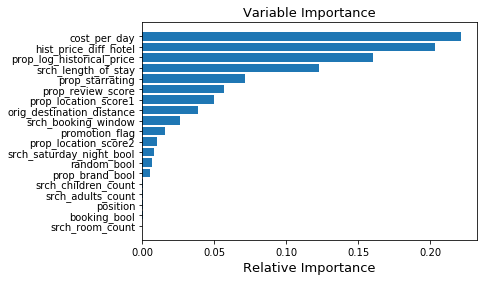

In [82]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot()
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_predict.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=13)
plt.title('Variable Importance',fontsize=13)
plt.show()

- `prop_log_historical_price` - The logarithm of the mean price of the hotel over the last trading period. A 0 will occur if the hotel was not sold in that period.

- `orig_destination_distance` - Physical distance between the hotel and the customer at the time of search. A null means the distance could not be calculated.

[0.5 1.5 2.5 3.5 4.5]


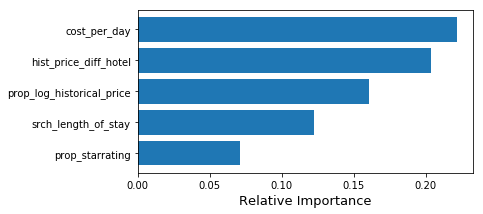

In [83]:
sorted_idx = np.argsort(feature_importance) # return indexes of the elements sorted in ascending order
sorted_idx = sorted_idx[-5:]
pos = np.arange(sorted_idx[-5:].shape[0]) + .5
print(pos)
plt.subplots(figsize=(6,3))
plt.barh(pos, feature_importance[sorted_idx[-5:]], align='center')
plt.yticks(pos, test_predict.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=13)
#plt.title('Feature Importance',fontsize=13)
plt.show()

#### Lets have a look at residuals

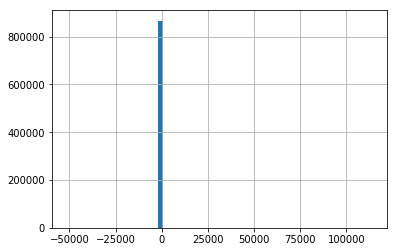

In [84]:
test_predict['price_difference'].hist(bins=60)

Text(0,0.5,'Price difference')

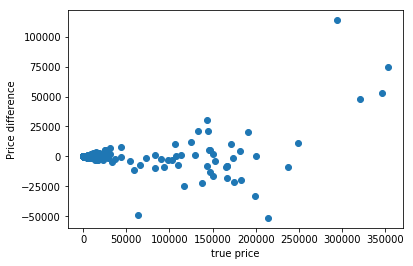

In [85]:
plt.scatter(test_predict.price_usd,test_predict.price_difference)
plt.xlabel("true price")
plt.ylabel("Price difference")

From the above plot we see that at least for one hotel the price is too high (to compare to the estimated price), hence this might be an outlier.

It is interesting to conduct the same experiment but with time features (`data_time`). Let say we could engineer three more features `month`, `week`, `day`, one - hot encode it (the obtained matrix is going to be sparse one) and use these features in regression as well.

## Adding time features

In [87]:
#data_time_feature = pd.to_datetime(data_time_feature)
#data_time_feature.head()

usa_time = usa.assign(date_time=data_time_feature)
usa_time.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,srch_children_count,srch_room_count,srch_saturday_night_bool,orig_destination_distance,random_bool,booking_bool,hist_price_diff_hotel,cost_per_day,price_usd,date_time
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,...,0,1,1,455.25,0,0,-78.000000,26.33,79.0,2013-06-10 04:00:38
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,...,0,1,0,38.27,0,0,15.481491,35.40,177.0,2012-11-10 12:21:39
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,...,0,1,0,530.30,0,0,15.584285,50.00,100.0,2013-02-19 12:38:46
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,0,2,0,45.35,0,0,-12.229927,120.00,120.0,2013-05-13 16:47:54
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,2,1,0,1559.34,1,0,-205.000000,68.67,206.0,2013-06-10 10:54:52


In [88]:
# Secondly, let us extract months:

usa_time['Month'] = usa_time['date_time'].apply(lambda x: int(str(x)[5:7]) if x == x else 
                                                     np.nan)
usa_time['Month'].head(5)

1478499     6
6971046    11
3923478     2
982566      5
3332016     6
Name: Month, dtype: int64

In [89]:
# Lastly, let us extract week:

usa_time['Day'] = usa_time['date_time'].apply(lambda x: int(str(x)[8:10]) if x == x else 
                                                     np.nan)
usa_time['Day'].head(5)

1478499    10
6971046    10
3923478    19
982566     13
3332016    10
Name: Day, dtype: int64

In [90]:
usa_time.shape

(2889568, 23)

In [91]:
usa_time = pd.get_dummies(usa_time, prefix=['Month','Day'], columns=['Month','Day'])
usa_time.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,...,0,0,0,0,0,0,0,0,0,0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,...,0,0,0,0,0,0,0,0,0,0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,...,0,0,0,0,0,0,0,0,0,0
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,0,0,0,0,0,0,0,0,0,0


In [92]:
usa_time = usa_time.drop('date_time', axis=1)
usa_time.head()

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,...,0,0,0,0,0,0,0,0,0,0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,...,0,0,0,0,0,0,0,0,0,0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,...,0,0,0,0,0,0,0,0,0,0
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,0,0,0,0,0,0,0,0,0,0


In [93]:
# Re-group columns
cols = list(usa_time.columns.values) 
cols.pop(cols.index('price_usd')) #Remove b from list
usa_time = usa_time[cols+['price_usd']]
usa_time.head(5)

,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,position,promotion_flag,srch_length_of_stay,srch_booking_window,...,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,price_usd
1478499,3,4.0,1,1.10,0.00440,0.00,7,0,3,25,...,0,0,0,0,0,0,0,0,0,79.0
6971046,4,3.5,0,5.07,0.05100,5.26,6,1,5,22,...,0,0,0,0,0,0,0,0,0,177.0
3923478,3,5.0,1,1.39,0.12434,4.75,3,1,2,1,...,0,0,0,0,0,0,0,0,0,100.0
982566,2,4.0,1,1.79,0.45230,4.68,6,0,1,0,...,0,0,0,0,0,0,0,0,0,120.0
3332016,4,4.0,1,3.09,0.12434,0.00,33,1,3,22,...,0,0,0,0,0,0,0,0,0,206.0


Now the dimension of the data has increased quite a lot. Let us run the same training procedure in order to see whether it helps or not.

In [94]:
train_time = usa_time[msk]
test_time = usa_time[~msk]

Y = train_time.iloc[:,-1]
X = train_time.drop([usa.columns[-1]], axis=1)


X_train, X_holdout, y_train, y_holdout = train_test_split(X.values, Y, test_size=0.3, 
                                                          random_state=17)

In [95]:
print(train_time.shape,test_time.shape)

((2022843, 59), (866725, 59))


In [98]:
score_lasso_rmse,score_lasso_mae = rmse_mae(lasso)
score_ridge_rmse,score_ridge_mae = rmse_mae(Ridge)
score_enet_rmse,score_enet_mae = rmse_mae(ENet)
score_xgb_rmse,score_xgb_mae = rmse_mae(model_xgb)
score_lgb_rmse,score_lgb_mae = rmse_mae(model_lgb)

print("Lasso score RMSE: {:.4f} ({:.4f})\n".format(score_lasso_rmse.mean(), score_lasso_rmse.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_rmse.mean(), score_ridge_rmse.std()))
print("ElasticNet score RMSE: {:.4f} ({:.4f})\n".format(score_enet_rmse.mean(), score_enet_rmse.std()))
print("Xgboost score RMSE: {:.4f} ({:.4f})\n".format(score_xgb_rmse.mean(), score_xgb_rmse.std()))
print("LGBM score RMSE: {:.4f} ({:.4f})\n" .format(score_lgb_rmse.mean(), score_lgb_rmse.std()))

print("\nLasso score MAE: {:.4f} ({:.4f})\n".format(score_lasso_mae.mean(), score_lasso_mae.std()))
print("Ridge score RMSE: {:.4f} ({:.4f})\n".format(score_ridge_mae.mean(), score_ridge_mae.std()))
print("ElasticNet score MAE: {:.4f} ({:.4f})\n".format(score_enet_mae.mean(), score_enet_mae.std()))
print("Xgboost score MAE: {:.4f} ({:.4f})\n".format(score_xgb_mae.mean(), score_xgb_mae.std()))
print("LGBM score MAE: {:.4f} ({:.4f})\n" .format(score_lgb_mae.mean(), score_lgb_mae.std()))

Lasso score RMSE: 48.4476 (0.2562)

Ridge score RMSE: 48.4476 (0.2563)

ElasticNet score RMSE: 48.4478 (0.2557)

Xgboost score RMSE: 78.7341 (44.1514)

LGBM score RMSE: 1178.4465 (362.8271)


Lasso score MAE: 5.5945 (0.0076)

Ridge score RMSE: 5.5944 (0.0076)

ElasticNet score MAE: 5.5965 (0.0076)

Xgboost score MAE: 1.8456 (0.1238)

LGBM score MAE: 7.1682 (0.0474)



In [99]:
regressions(lasso)

MAE : 31.262827
RMSE : 48.397551
R2 : 0.998740


In [100]:
regressions(ENet)

MAE : 31.285060
RMSE : 48.397032
R2 : 0.998740


In [101]:
regressions(model_xgb)

MAE : 3.150323
RMSE : 137.726972
R2 : 0.989794


In [102]:
regressions(model_lgb)

MAE : 48.376333
RMSE : 1232.000450
R2 : 0.183350


In [103]:
#Lets find and plot features which are actually important for out XGB model

feature_importance = model_xgb.feature_importances_
print(np.argsort(feature_importance)[:5])

[41 55 36 50 42]


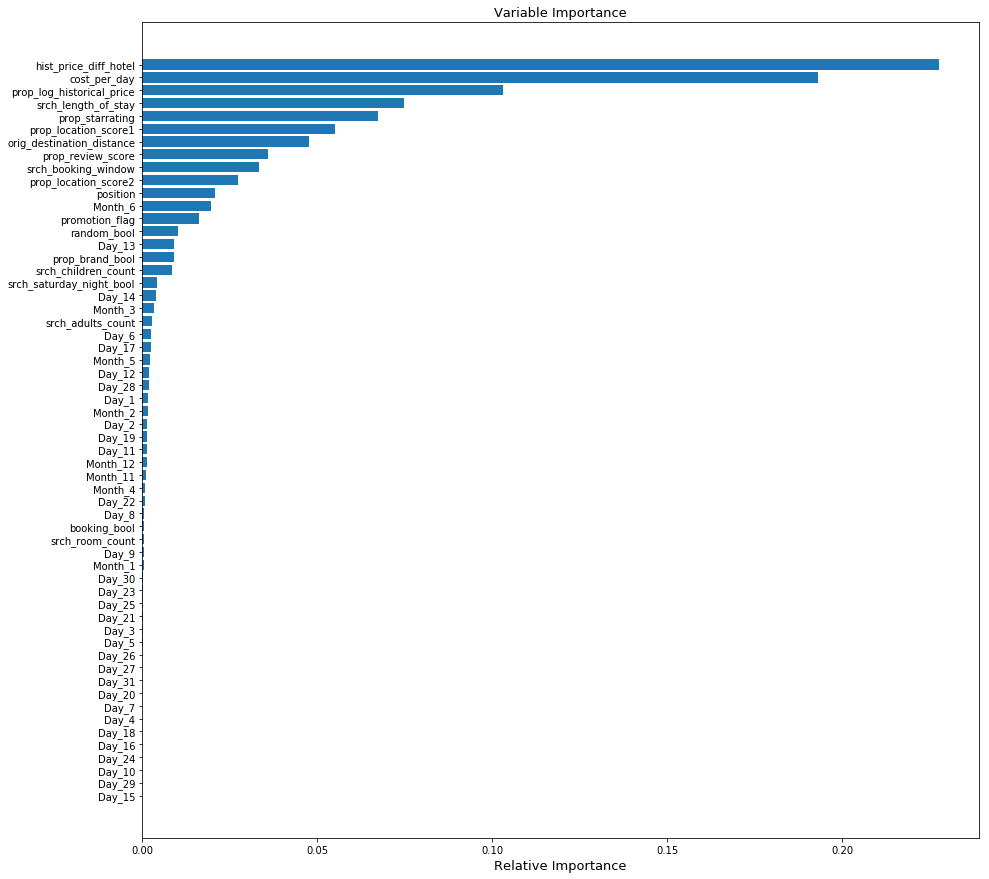

In [105]:
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15,15))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, test_time.columns[sorted_idx])
plt.xlabel('Relative Importance', fontsize=13)
plt.title('Variable Importance',fontsize=13)
plt.show()

The one can see that feature engineering helped us to improve results in terms of *RMSE* and *MAE* (we are comparing with the first case, the one without log-transformation of target). Also, a few generated **time features** appeared in the top - 15 features relevance, which proves that **Feature Engineering** is a right way to go, and there is the big room for improvements.